
# Sequence Extraction Using Pyfaidx


In [11]:
sample_count_threshold = 50;


## Imports & Path Set-up


In [12]:
import random
import math
import pandas as pd
import numpy as np
from pyfaidx import Fasta
import matplotlib.pyplot as plt

PATH = '../GenomeData/'


## Preprocessed Data Handling


The provided data needs to be read into a pandas data frame for further processing...

In [13]:
ubsseq_data_raw = pd.read_excel("ubsseq_preprocessed_data.xlsx")
ubsseq_data_raw_shape = ubsseq_data_raw.shape

c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
c:\Users\joele\JoelsPrograms\miniconda3\envs\MLRNA\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


The data needs to be filtered to remove genes that were not sampled enough to be statistically significant, this is determined by the unconverted/converted attribute. If the combined sum of these attributes is less than ??? then the gene has not shown enough influence from methylation to be considered.

In [14]:
ubsseq_data_sample_count = ubsseq_data_raw[['unconverted', 'converted']].sum(axis=1)
ubsseq_data_significant = ubsseq_data_raw[ubsseq_data_sample_count > sample_count_threshold]
ubsseq_data_significant_shape = ubsseq_data_significant.shape
print(f"Filtered data contains {ubsseq_data_significant_shape[0]} genes out of an initial {ubsseq_data_raw_shape[0]} genes, a {ubsseq_data_significant_shape[0]/ubsseq_data_raw_shape[0]*100:.2f}% retention")

Filtered data contains 1605 genes out of an initial 2140 genes, a 75.00% retention



## Ratio Control Selection


A scatter graph will show the correlation between the control ratio and NSUN6 ratio to help determine which genes should be selected for the positive data set. 
- Can do both a strict and relax cut-off.

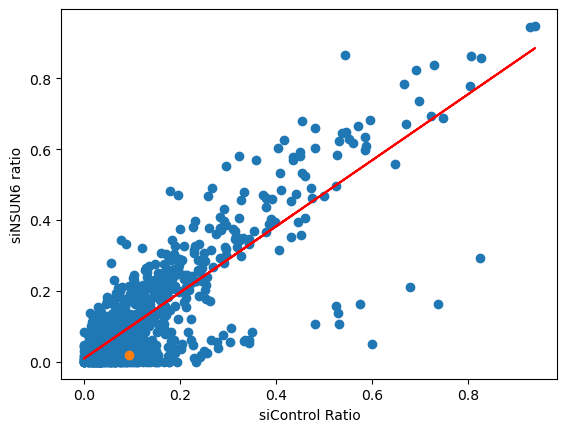

In [27]:
plt.scatter(ubsseq_data_significant['ratio_siControl'], ubsseq_data_significant['ratio_siNSUN6'], label='Data Points')
plt.xlabel('siControl Ratio')
plt.ylabel('siNSUN6 ratio')

a, b = np.polyfit(ubsseq_data_significant['ratio_siControl'], ubsseq_data_significant['ratio_siNSUN6'], 1)
plt.plot(ubsseq_data_significant['ratio_siControl'], a * np.array(ubsseq_data_significant['ratio_siControl']) + b, color='red', label='Line of Best Fit')

# Joel's Test for Understanding
#gene_search = ubsseq_data_significant[ubsseq_data_significant['gene_name'] == "ENSG00000083444(PLOD1)"]
gene_search = ubsseq_data_significant[ubsseq_data_significant['delta_ratio'] > 0.7]
plt.scatter(gene_search['ratio_siControl'], gene_search['ratio_siNSUN6'], label='Gene Search')

plt.show()

delta ratio will be (control - NSUN6) / control

In [33]:
print(f"Best fit gradient is {a:.2f} and y-intercept is {b:.2f}")
print(f"Ideal data threshold should be above delta ratio {(1-a) * 100:.2f}%")

temp = ubsseq_data_significant['delta_ratio'] > 0.5
gene_search = ubsseq_data_significant[ubsseq_data_significant['delta_ratio'] > 0.7]
print(gene_search)

Best fit gradient is 0.93 and y-intercept is 0.01
Ideal data threshold should be above delta ratio 6.85%
     chrom        pos strand       gene_type                 gene_name  \
4        1    1046450      +  protein_coding     ENSG00000188157(AGRN)   
6        1    1050461      +  protein_coding     ENSG00000188157(AGRN)   
34       1   11975276      +  protein_coding    ENSG00000083444(PLOD1)   
35       1   16396171      +  protein_coding    ENSG00000055070(SZRD1)   
47       1   20652451      -  protein_coding    ENSG00000244038(DDOST)   
...    ...        ...    ...             ...                       ...   
2121     X  151623046      +  protein_coding    ENSG00000166049(PASD1)   
2124     X  153700859      -  protein_coding   ENSG00000185825(BCAP31)   
2134     X  154368020      -  protein_coding     ENSG00000196924(FLNA)   
2135     X  154429108      +  protein_coding  ENSG00000071553(ATP6AP1)   
2138     X  154488508      -  protein_coding  ENSG00000126903(SLC10A3)   

      


## Sequence Extraction



## Saving Back To Fasta
